In [1]:
import pandas as pd
import os
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta, datetime
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from tqdm import tqdm
import warnings
from pmdarima.arima import auto_arima
warnings.filterwarnings('ignore')
from pmdarima.arima import auto_arima


from chart_studio import plotly


plt.style.use('ggplot')

# One Stock

In [2]:
path = './data'
sample_name = 'sample_submission.csv'
sample_submission = pd.read_csv(os.path.join(path,sample_name))
list_name = 'Stock_List.csv'
stock_list = pd.read_csv(os.path.join(path,list_name))
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list

,종목명,종목코드,상장시장
0,삼성전자,005930,KOSPI
1,SK하이닉스,000660,KOSPI
2,NAVER,035420,KOSPI
3,카카오,035720,KOSPI
4,삼성바이오로직스,207940,KOSPI
...,...,...,...
365,맘스터치,220630,KOSDAQ
366,다날,064260,KOSDAQ
367,제이시스메디칼,287410,KOSDAQ
368,크리스에프앤씨,110790,KOSDAQ


In [3]:
stock_list['종목코드'][:5].values

array(['005930', '000660', '035420', '035720', '207940'], dtype=object)

In [4]:
start_date = '20210104'
end_date = '20211029'
KOSIP = fdr.DataReader('KS200', start = start_date, end = end_date)[['Close']].reset_index()
KOSDAQ = fdr.DataReader('KQ11', start = start_date, end = end_date)[['Close']].reset_index()
ks = KOSIP[['Close']]
kq = KOSDAQ[['Close']]
df_exogenous = pd.concat([ks, kq], axis=1)
df_exogenous.columns = ['ks_Close', 'kq_Close']
df_exogenous

,ks_Close,kq_Close
0,399.88,977.62
1,406.03,985.76
2,402.08,981.39
3,410.81,988.86
4,430.22,987.79
...,...,...
199,395.01,994.31
200,399.07,1011.76
201,395.48,1008.95
202,393.89,1000.13


In [5]:

samsung = fdr.DataReader('005930', start = start_date, end = end_date)[['Close']].reset_index().set_index('Date')
samsung

,Close
Date,
2021-01-04,83000
2021-01-05,83900
2021-01-06,82200
2021-01-07,82900
2021-01-08,88800
...,...
2021-10-25,70200
2021-10-26,71100
2021-10-27,70100


In [6]:
xt = np.log(samsung)
rt = 100*xt.diff().dropna()

In [7]:
xt

,Close
Date,
2021-01-04,11.326596
2021-01-05,11.337381
2021-01-06,11.316911
2021-01-07,11.325390
2021-01-08,11.394142
...,...
2021-10-25,11.159104
2021-10-26,11.171843
2021-10-27,11.157678


In [8]:
rt

,Close
Date,
2021-01-05,1.078501
2021-01-06,-2.047031
2021-01-07,0.847976
2021-01-08,6.875159
2021-01-11,2.447286
...,...
2021-10-25,-0.284495
2021-10-26,1.273903
2021-10-27,-1.416454


### a) Obtain the time plots of xt and rt (in one page, using the command par(mfcol=c(2,1)). In other words, obtain 2 plots in one window (time plots for xt and rt).

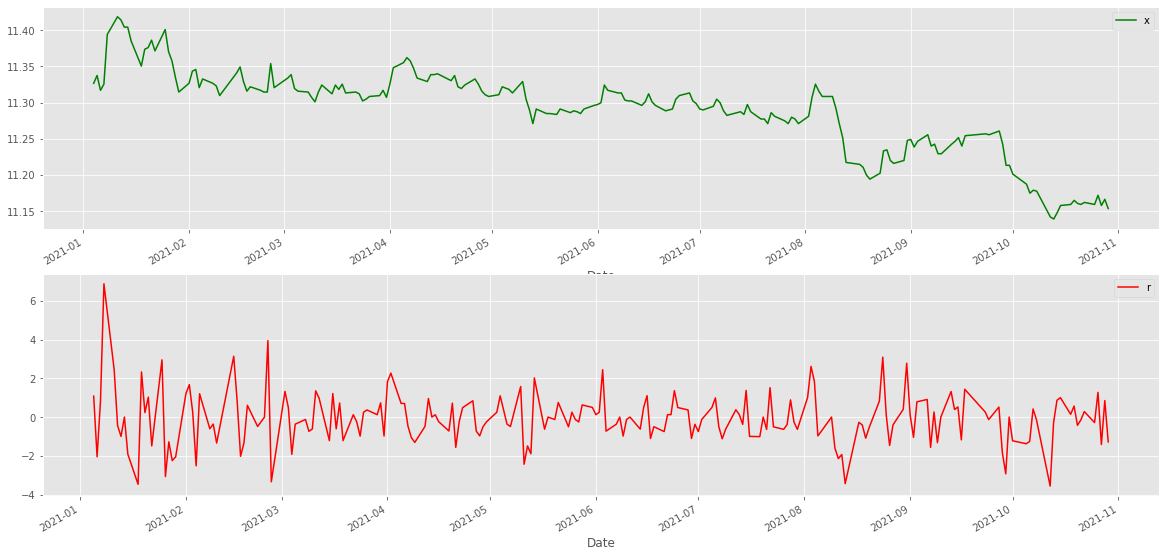

In [9]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)


xt.plot(ax=ax1, c='g')
rt.plot(ax=ax2, c='r')

ax1.legend('xt')
ax2.legend('rt')

### (b) Compute the first 12 lags of ACF of xt. Based on the ACF, is there a unit root in xt? Why?

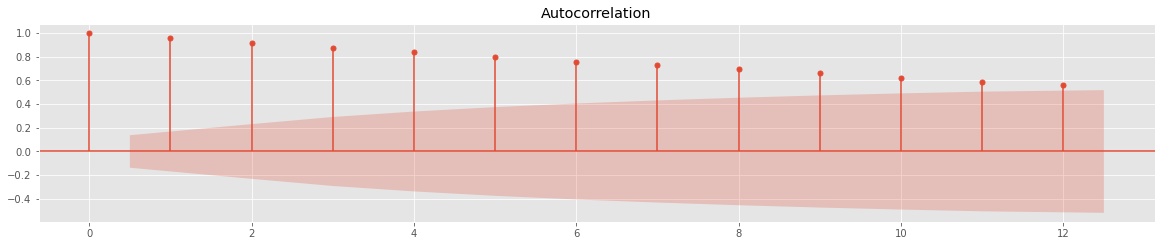

In [10]:
import statsmodels.api as sm

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(xt, lags=12, ax = ax1)

In [11]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(xt)
print('ADF Statistic : %f' % result[0])
print('p-value: %f'%result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f'%(key, value))

ADF Statistic : -0.889203
p-value: 0.791507
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574


H0 : Non-stationarity  
H1 : stationarity 

Because p-value is greater than 0.05, we can't reject H0 > Non-stationarity  
Hence, there exist unit root in xt.   
A time series is non-stationery.

### c) Let rt = 100*(xt – xt-1) be the return series of the gold prices, in percentages. Consider the rt series. Test H0 : p1 = ... = p12 = 0 versus Ha : pi ≠ 0 for some 1 ≤ i ≤ 12. Draw your conclusion.

In [12]:
rt

,Close
Date,
2021-01-05,1.078501
2021-01-06,-2.047031
2021-01-07,0.847976
2021-01-08,6.875159
2021-01-11,2.447286
...,...
2021-10-25,-0.284495
2021-10-26,1.273903
2021-10-27,-1.416454


In [13]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(rt, lags=12, return_df=True)

,lb_stat,lb_pvalue
1,0.312823,0.575953
2,1.435099,0.487947
3,1.849739,0.604171
4,2.376272,0.666919
5,7.549524,0.182872
6,11.581091,0.071994
7,13.507691,0.060663
8,13.656512,0.091169
9,13.680127,0.134167
10,13.682274,0.187984


H0 : The data are independently distributed  
H1 : The data are not independently distributed 

Because p-value is greater than 0.01, we can't reject H0.  
Hence, the data are independently distributed   
the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process

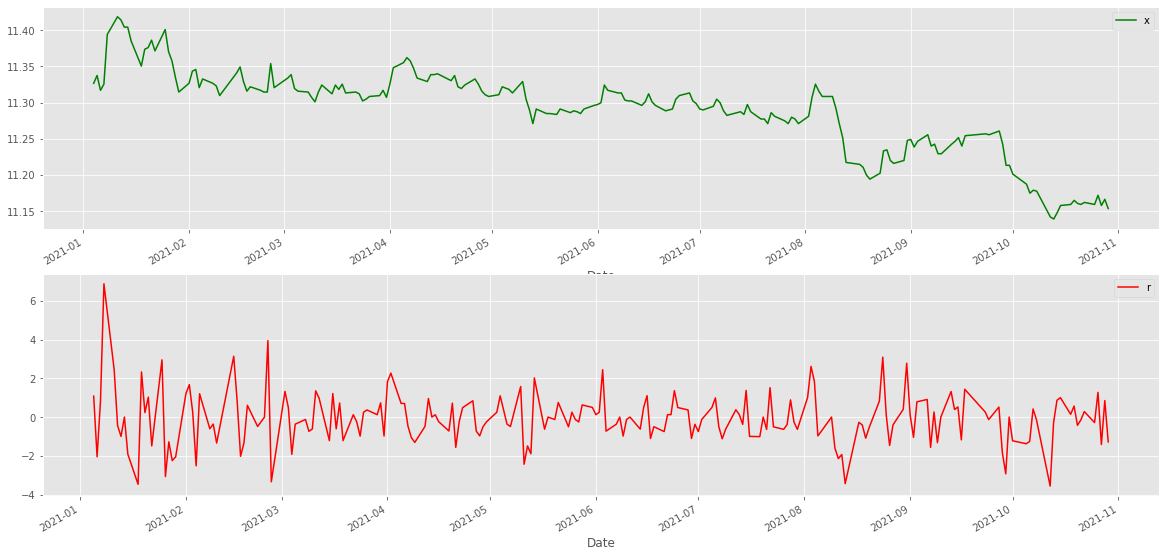

In [16]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)


xt.plot(ax=ax1, c='g')
rt.plot(ax=ax2, c='r')

ax1.legend('xt')
ax2.legend('rt')

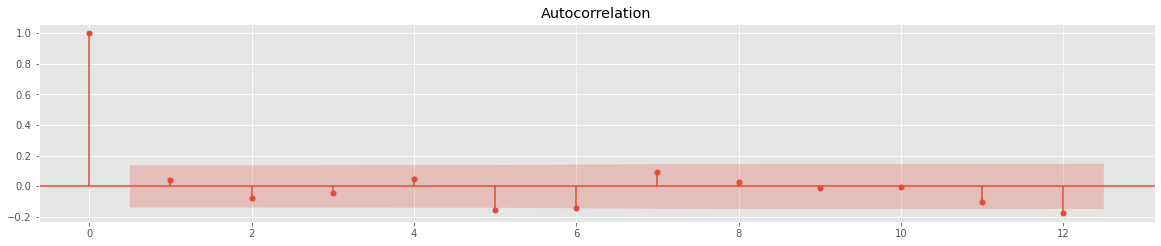

In [17]:
import statsmodels.api as sm

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(rt ,lags=12, ax = ax1)

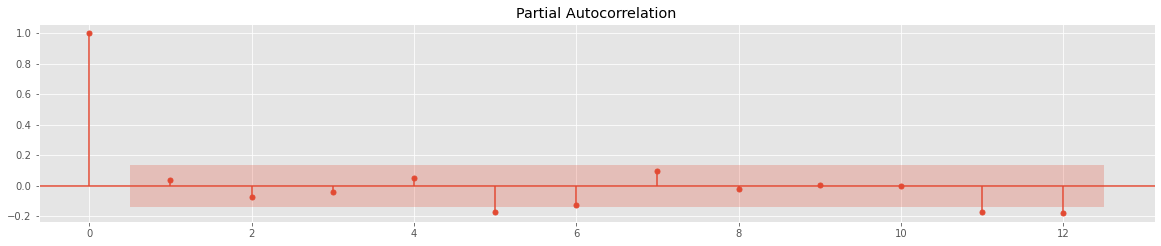

In [18]:
import statsmodels.api as sm

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(rt ,lags=12, ax = ax1)

### d) Use the command ar(rt,method="mle",order.max=10) to specify the order of an AR model for rt.


In [19]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

In [20]:
ar_model = AR(rt)

In [21]:
ar_model_fit = ar_model.fit(maxlag = 10, method='mle')

### (e) Build an AR model for rt, including model checking.

In [22]:
ar_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               AR Model Results                               
==============================================================================
Dep. Variable:                      C  -                  l                  o
Model:                         AR(10)   Log Likelihood                -340.358
Method:                           mle   S.D. of innovations              1.292
Date:                Tue, 07 Dec 2021   AIC                              0.631
Time:                        00:24:08   BIC                              0.827
Sample:                             0   HQIC                             0.711
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1190      0.096     -1.238      0.216      -0.307       0.069
L1.Close       0.0392      0.070      0.556      0.578      -0.099       0.177
L2.Close      -0.0579      0.071     -0.821      0.412      -0.196       0.080
L3.Close      -0.0655      0.071     -0.923      0.356      -0.205       0.074
L4.Close       0.0561      0.075      0.748      0.454      -0.091       0.203
L5.Close      -0.1913      0.075     -2.554      0.011      -0.338      -0.044
L6.Close      -0.1542      0.075     -2.048      0.041      -0.302      -0.007
L7.Close       0.1022      0.076      1.348      0.178      -0.046       0.251
L8.Close      -0.0131      0.076     -0.173      0.863      -0.162       0.136
L9.Close       0.0026      0.076      0.034      0.973      -0.146       0.151
L10.Close     -0.0023      0.076     -0.030      0.976      -0.152       0.147
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.2204           -0.4837j            1.3127           -0.4399
AR.2            -1.2204           +0.4837j            1.3127            0.4399
AR.3            -0.1717           -1.1851j            1.1974           -0.2729
AR.4            -0.1717           +1.1851j            1.1974            0.2729
AR.5             1.0177           -0.7992j            1.2940           -0.1059
AR.6             1.0177           +0.7992j            1.2940            0.1059
AR.7             2.4518           -1.0777j            2.6782           -0.0659
AR.8             2.4518           +1.0777j            2.6782            0.0659
AR.9            -1.5072           -3.5334j            3.8414           -0.3142
AR.10           -1.5072           +3.5334j            3.8414            0.3142
------------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='Date'>

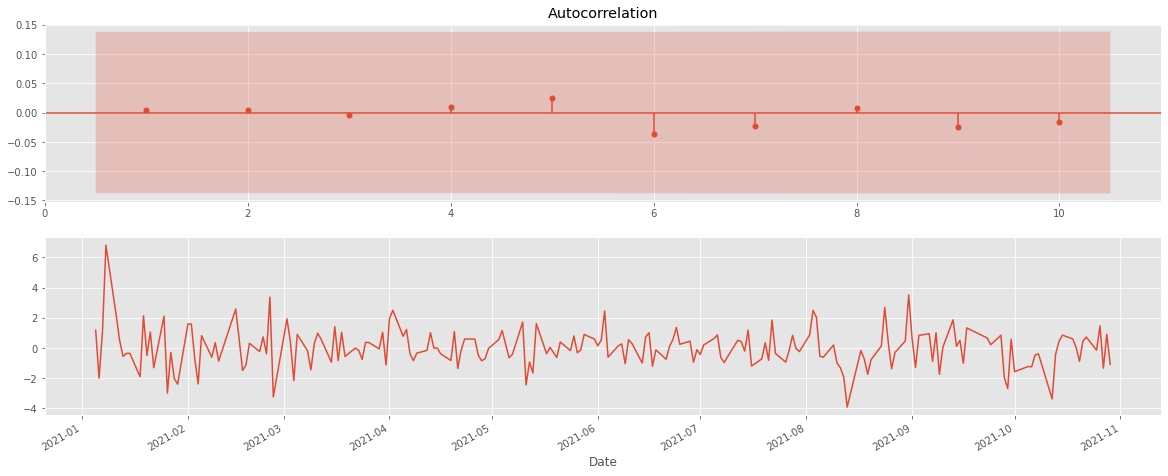

In [23]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)


sm.graphics.tsa.plot_acf(ar_model_fit.resid, lags=10, ax = ax1, zero=False)
ar_model_fit.resid.plot(ax=ax2)

In [24]:
lbp = sm.stats.acorr_ljungbox(ar_model_fit.resid, lags=10, return_df=True)
lbp

,lb_stat,lb_pvalue
1,0.003431,0.953291
2,0.006572,0.996719
3,0.009327,0.999761
4,0.030578,0.999884
5,0.167367,0.999426
6,0.445885,0.998436
7,0.556853,0.999211
8,0.570558,0.999780
9,0.699950,0.999872
10,0.752827,0.999954


H0 : The data are independently distributed  
H1 : The data are not independently distributed 

Because p-value is greater than 0.05, we can't reject H0.  
Hence, the data are independently distributed   
the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process

In [25]:
m_t_ratio = ar_model_fit.tvalues
m_t_ratio

const       -1.238229
L1.Close     0.556329
L2.Close    -0.820663
L3.Close    -0.923021
L4.Close     0.748409
L5.Close    -2.553853
L6.Close    -2.048400
L7.Close     1.348136
L8.Close    -0.172656
L9.Close     0.034415
L10.Close   -0.029960
dtype: float64

### f) Refine the model by excluding all estimates with t-ratio less than 1.96. Write down the fitted model.

In [26]:
m_t_ratio[abs(m_t_ratio) > 1.96]

L5.Close   -2.553853
L6.Close   -2.048400
dtype: float64

In [27]:
ar_final_model = AutoReg(samsung, lags=[5,6]).fit()

In [28]:
ar_final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  Close   No. Observations:                  204
Model:              Restr. AutoReg(6)   Log Likelihood               -1808.639
Method:               Conditional MLE   S.D. of innovations           2243.077
Date:                Tue, 07 Dec 2021   AIC                             15.472
Time:                        00:24:13   BIC                             15.538
Sample:                             6   HQIC                            15.499
                                  204                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7671.8145   3042.451      2.522      0.012    1708.720    1.36e+04
Close.L5       0.7460      0.145      5.153      0.000       0.462       1.030
Close.L6       0.1536      0.147      1.048      0.295      -0.134       0.441
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0207           -0.0000j            1.0207           -0.0000
AR.2            0.3584           -0.9782j            1.0418           -0.1941
AR.3            0.3584           +0.9782j            1.0418            0.1941
AR.4           -0.8676           -0.6760j            1.0998           -0.3947
AR.5           -0.8676           +0.6760j            1.0998            0.3947
AR.6           -4.8587           -0.0000j            4.8587           -0.5000
-----------------------------------------------------------------------------
"""

### g) Use the fitted AR model to compute 1-step to 5-step ahead forecasts of rt at the forecast origin March 30, 2017. Also, compute the corresponding 95% interval forecasts.

In [29]:
ar_forecast = ar_final_model.forecast(5)
ar_forecast

204    70852.335077
205    71492.979646
206    70885.264091
207    71179.233979
208    70600.032406
dtype: float64

In [30]:
test_start_date = '20211030'
test_end_date = '20211105'
test_samsung = fdr.DataReader('005930', start = test_start_date, end = test_end_date)[['Close']].reset_index().set_index('Date')
test_samsung

,Close
Date,
2021-11-01,69900
2021-11-02,71500
2021-11-03,70400
2021-11-04,70600
2021-11-05,70200


# Several Stock

# Getting Weight

### ARIMA predict

In [119]:
path = './data'
sample_name = 'sample_submission.csv'
sample_submission = pd.read_csv(os.path.join(path,sample_name))
list_name = 'Stock_List.csv'
stock_list = pd.read_csv(os.path.join(path,list_name))
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list

,종목명,종목코드,상장시장
0,삼성전자,005930,KOSPI
1,SK하이닉스,000660,KOSPI
2,NAVER,035420,KOSPI
3,카카오,035720,KOSPI
4,삼성바이오로직스,207940,KOSPI
...,...,...,...
365,맘스터치,220630,KOSDAQ
366,다날,064260,KOSDAQ
367,제이시스메디칼,287410,KOSDAQ
368,크리스에프앤씨,110790,KOSDAQ


In [120]:
stock_list['종목코드'][:5].values

array(['005930', '000660', '035420', '035720', '207940'], dtype=object)

In [121]:
start_date = '20210104'
end_date = '20211024'
KOSIP = fdr.DataReader('KS200', start = start_date, end = end_date)[['Close']].reset_index()
KOSDAQ = fdr.DataReader('KQ11', start = start_date, end = end_date)[['Close']].reset_index()
ks = KOSIP[['Close']]
kq = KOSDAQ[['Close']]
df_exogenous = pd.concat([ks, kq], axis=1)
df_exogenous.columns = ['ks_Close', 'kq_Close']
df_exogenous

,ks_Close,kq_Close
0,399.88,977.62
1,406.03,985.76
2,402.08,981.39
3,410.81,988.86
4,430.22,987.79
...,...,...
194,392.02,993.86
195,395.41,1005.35
196,393.74,1001.62
197,393.18,993.70


In [122]:
sample_code = stock_list.loc[0,'종목코드']

for code in tqdm(stock_list['종목코드'].values):
    data = fdr.DataReader(code, start = start_date, end = end_date)[['Close']].reset_index()
    X = data.Close.values
    model_arima= auto_arima(X, exogenous = df_exogenous[['ks_Close', 'kq_Close']], 
                            max_p = 10, max_q = 10, max_d = 1,
                            alpha = 0.05, n_jobs = -1, 
                            out_of_sample_size= int(len(X)*0.2), seasonal = False
                       )
    try:
        best_model = model_arima.fit(X)
    except:
        y_pred = data.Close.values[-1] * 5
        sample_submission[code][:5] = y_pred
        print(code)
        continue
        
    y_pred = best_model.predict(n_periods=5)
    sample_submission[code][:5] = y_pred

100%|██████████| 370/370 [08:26<00:00,  1.37s/it]


In [123]:
sample_submission

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-11-01,29173.937576,36100.0,61837.104754,148975.748755,96400.0,17340.285016,48219.647576,83393.104462,98500.0,...,45700.0,50600.0,82000.0,34468.907684,26487.751031,50970.077922,325799.245283,255000.0,27706.199023,17901.421585
1,2021-11-02,29247.875151,36100.0,61709.237271,148951.501458,96400.0,17330.575471,48107.332456,83387.086661,98500.0,...,45700.0,50600.0,82000.0,34437.843389,26327.187615,50940.173400,326598.490566,255000.0,27712.210027,17875.232086
2,2021-11-03,29321.812727,36100.0,61660.928518,148927.258107,96400.0,17320.871363,48009.524350,83381.834871,98500.0,...,45700.0,50600.0,82000.0,34406.807090,26171.348229,50910.286423,327397.735849,255000.0,27718.038716,17812.194053
3,2021-11-04,29395.750302,36100.0,61569.224695,148903.018701,96400.0,17311.172689,47905.131898,83377.251584,98500.0,...,45700.0,50600.0,82000.0,34375.798762,26015.046943,50880.416981,328196.981132,255000.0,27723.690619,17743.383893
4,2021-11-05,29469.687878,36100.0,61504.866571,148878.783241,96400.0,17301.479445,47803.727905,83373.251706,98500.0,...,45700.0,50600.0,82000.0,34344.818379,25858.790820,50850.565064,328996.226415,255000.0,27729.171097,17673.863388
5,2021-11-29,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
6,2021-11-30,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
7,2021-12-01,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
8,2021-12-02,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
9,2021-12-03,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


In [124]:
ar = sample_submission.copy()

In [307]:
ar.Day = ['2021-10-25', '2021-10-26', '2021-10-27', '2021-10-28', '2021-10-29', '2021-11-01', '2021-11-02', '2021-11-03', '2021-11-04', '2021-11-05']
ar

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-10-25,29173.937576,36100.0,61837.104754,148975.748755,96400.0,17340.285016,48219.647576,83393.104462,98500.0,...,45700.0,50600.0,82000.0,34468.907684,26487.751031,50970.077922,325799.245283,255000.0,27706.199023,17901.421585
1,2021-10-26,29247.875151,36100.0,61709.237271,148951.501458,96400.0,17330.575471,48107.332456,83387.086661,98500.0,...,45700.0,50600.0,82000.0,34437.843389,26327.187615,50940.173400,326598.490566,255000.0,27712.210027,17875.232086
2,2021-10-27,29321.812727,36100.0,61660.928518,148927.258107,96400.0,17320.871363,48009.524350,83381.834871,98500.0,...,45700.0,50600.0,82000.0,34406.807090,26171.348229,50910.286423,327397.735849,255000.0,27718.038716,17812.194053
3,2021-10-28,29395.750302,36100.0,61569.224695,148903.018701,96400.0,17311.172689,47905.131898,83377.251584,98500.0,...,45700.0,50600.0,82000.0,34375.798762,26015.046943,50880.416981,328196.981132,255000.0,27723.690619,17743.383893
4,2021-10-29,29469.687878,36100.0,61504.866571,148878.783241,96400.0,17301.479445,47803.727905,83373.251706,98500.0,...,45700.0,50600.0,82000.0,34344.818379,25858.790820,50850.565064,328996.226415,255000.0,27729.171097,17673.863388
5,2021-11-01,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
6,2021-11-02,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
7,2021-11-03,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
8,2021-11-04,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
9,2021-11-05,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


In [308]:
ar.to_csv('save/AUTO_ARIMA.csv', index=False)

In [33]:
ar = pd.read_csv('save/AUTO_ARIMA.csv')
ar

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-10-25,29173.937576,36100.0,61837.104754,148975.748755,96400.0,17340.285016,48219.647576,83393.104462,98500.0,...,45700.0,50600.0,82000.0,34468.907684,26487.751031,50970.077922,325799.245283,255000.0,27706.199023,17901.421585
1,2021-10-26,29247.875151,36100.0,61709.237271,148951.501458,96400.0,17330.575471,48107.332456,83387.086661,98500.0,...,45700.0,50600.0,82000.0,34437.843389,26327.187615,50940.173400,326598.490566,255000.0,27712.210027,17875.232086
2,2021-10-27,29321.812727,36100.0,61660.928518,148927.258107,96400.0,17320.871363,48009.524350,83381.834871,98500.0,...,45700.0,50600.0,82000.0,34406.807090,26171.348229,50910.286423,327397.735849,255000.0,27718.038716,17812.194053
3,2021-10-28,29395.750302,36100.0,61569.224695,148903.018701,96400.0,17311.172689,47905.131898,83377.251584,98500.0,...,45700.0,50600.0,82000.0,34375.798762,26015.046943,50880.416981,328196.981132,255000.0,27723.690619,17743.383893
4,2021-10-29,29469.687878,36100.0,61504.866571,148878.783241,96400.0,17301.479445,47803.727905,83373.251706,98500.0,...,45700.0,50600.0,82000.0,34344.818379,25858.790820,50850.565064,328996.226415,255000.0,27729.171097,17673.863388
5,2021-11-01,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
6,2021-11-02,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
7,2021-11-03,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
8,2021-11-04,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
9,2021-11-05,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


### ML Modeling

In [34]:
start_date = '20210104'
end_date = '20211031'


start_weekday = pd.to_datetime(start_date).weekday()
max_weeknum = pd.to_datetime(end_date).strftime('%V')
Business_days = pd.DataFrame(pd.date_range(start_date,end_date,freq='B'), columns = ['Date'])

print(f'WEEKDAY of "start_date" : {start_weekday}')
print(f'NUM of WEEKS to "end_date" : {max_weeknum}')
print(f'HOW MANY "Business_days" : {Business_days.shape}', )
display(Business_days.head())

WEEKDAY of "start_date" : 0
NUM of WEEKS to "end_date" : 43
HOW MANY "Business_days" : (215, 1)


,Date
0,2021-01-04
1,2021-01-05
2,2021-01-06
3,2021-01-07
4,2021-01-08


In [35]:
Business_days.tail()

,Date
210,2021-10-25
211,2021-10-26
212,2021-10-27
213,2021-10-28
214,2021-10-29


In [36]:
sample_code = stock_list.loc[0,'종목코드']

sample = fdr.DataReader(sample_code, start = start_date, end = end_date)[['Close']].reset_index()
sample = pd.merge(Business_days, sample, how = 'outer')
sample['weekday'] = sample.Date.apply(lambda x : x.weekday())
sample['weeknum'] = sample.Date.apply(lambda x : x.strftime('%V'))
sample.Close = sample.Close.ffill()
sample = pd.pivot_table(data = sample, values = 'Close', columns = 'weekday', index = 'weeknum')
sample.head()

weekday,0,1,2,3,4
weeknum,,,,,
01,83000.0,83900.0,82200.0,82900.0,88800.0
02,91000.0,90600.0,89700.0,89700.0,88000.0
03,85000.0,87000.0,87200.0,88100.0,86800.0
04,89400.0,86700.0,85600.0,83700.0,82000.0
05,83000.0,84400.0,84600.0,82500.0,83500.0


In [39]:
!pip install catboost

     |████████████████████████████████| 12.8 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 46 kB 2.1 MB/s eta 0:00:01


In [62]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()

In [63]:
x = sample.iloc[0:-2].to_numpy()
x.shape

(41, 5)

In [64]:
y = sample.iloc[1:-1].to_numpy()
y_0 = y[:,0]
y_1 = y[:,1]
y_2 = y[:,2]
y_3 = y[:,3]
y_4 = y[:,4]

y_values = [y_0, y_1, y_2, y_3, y_4]

In [65]:
x_public = sample.iloc[-2].to_numpy()

In [66]:
predictions = []
for y_value in y_values :
    model.fit(x,y_value)
    prediction = model.predict(np.expand_dims(x_public,0))
    predictions.append(prediction[0])
predictions

[70969.0, 70372.0, 70919.0, 70562.0, 70744.0]

In [67]:
sample.iloc[-1].values

array([70200., 71100., 70100., 70700., 69800.])

In [68]:
sample_name = 'sample_submission.csv'
sample_submission = pd.read_csv(os.path.join(path,sample_name))

In [69]:
sample_submission.loc[:4]

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-11-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-11-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-11-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-11-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-11-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
for code in tqdm(stock_list['종목코드'].values):
    data = fdr.DataReader(code, start = start_date, end = end_date)[['Close']].reset_index()
    data = pd.merge(Business_days, data, how = 'outer')
    data['weekday'] = data.Date.apply(lambda x : x.weekday())
    data['weeknum'] = data.Date.apply(lambda x : x.strftime('%V'))
    data.Close = data.Close.ffill()
    data = pd.pivot_table(data = data, values = 'Close', columns = 'weekday', index = 'weeknum')
    
    x = data.iloc[0:-2].to_numpy() # 2021년 1월 04일 ~ 2021년 10월 22일까지의 데이터로
    y = data.iloc[1:-1].to_numpy() # 2021년 1월 11일 ~ 2021년 10월 29일까지의 데이터를 학습한다.
    y_0 = y[:,0]
    y_1 = y[:,1]
    y_2 = y[:,2]
    y_3 = y[:,3]
    y_4 = y[:,4]

    y_values = [y_0, y_1, y_2, y_3, y_4]
    x_public = data.iloc[-2].to_numpy() # 2021년 11월 1일부터 11월 5일까지의 데이터를 예측할 것이다.
    
    predictions = []
    for y_value in y_values :
        model.fit(x,y_value)
        prediction = model.predict(np.expand_dims(x_public,0))
        predictions.append(prediction[0])
    sample_submission.loc[:4,code] = predictions
sample_submission.isna().sum().sum()

100%|██████████| 370/370 [05:44<00:00,  1.07it/s]


0

In [71]:
rf = sample_submission.copy()

In [72]:
rf.Day = ['2021-10-25', '2021-10-26', '2021-10-27', '2021-10-28', '2021-10-29', '2021-11-01', '2021-11-02', '2021-11-03', '2021-11-04', '2021-11-05']
rf

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-10-25,29309.0,35894.5,61384.0,148750.0,95598.0,17198.5,48527.5,84510.0,96837.0,...,45288.0,50370.0,83465.0,33327.5,27190.0,50415.0,312300.0,256963.0,27476.0,17231.0
1,2021-10-26,29779.0,36071.5,61073.0,149575.0,94136.0,17465.0,44598.0,84023.0,95864.0,...,45206.0,49740.5,83777.0,33542.0,27092.5,51075.0,302385.0,251426.0,27739.0,16482.5
2,2021-10-27,29708.0,36502.0,61173.0,150175.0,96233.0,17313.0,43294.5,83543.0,96323.0,...,45250.5,49810.5,84831.0,33267.0,26649.0,51335.0,297150.0,250648.0,26430.0,16905.5
3,2021-10-28,30469.5,36321.0,61399.0,151490.0,96040.0,17265.0,45464.5,83670.0,95956.0,...,46618.0,49612.5,81598.0,32941.0,27331.5,53669.0,304445.0,252553.0,26144.5,18601.5
4,2021-10-29,30038.0,36120.0,61424.0,149700.0,96270.0,17291.5,46609.5,81412.0,98386.0,...,46581.0,49656.0,81063.0,31432.5,28300.5,53251.0,300955.0,261909.0,26539.0,17789.0
5,2021-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2021-11-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2021-11-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2021-11-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2021-11-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [310]:
ar

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-10-25,29173.937576,36100.0,61837.104754,148975.748755,96400.0,17340.285016,48219.647576,83393.104462,98500.0,...,45700.0,50600.0,82000.0,34468.907684,26487.751031,50970.077922,325799.245283,255000.0,27706.199023,17901.421585
1,2021-10-26,29247.875151,36100.0,61709.237271,148951.501458,96400.0,17330.575471,48107.332456,83387.086661,98500.0,...,45700.0,50600.0,82000.0,34437.843389,26327.187615,50940.173400,326598.490566,255000.0,27712.210027,17875.232086
2,2021-10-27,29321.812727,36100.0,61660.928518,148927.258107,96400.0,17320.871363,48009.524350,83381.834871,98500.0,...,45700.0,50600.0,82000.0,34406.807090,26171.348229,50910.286423,327397.735849,255000.0,27718.038716,17812.194053
3,2021-10-28,29395.750302,36100.0,61569.224695,148903.018701,96400.0,17311.172689,47905.131898,83377.251584,98500.0,...,45700.0,50600.0,82000.0,34375.798762,26015.046943,50880.416981,328196.981132,255000.0,27723.690619,17743.383893
4,2021-10-29,29469.687878,36100.0,61504.866571,148878.783241,96400.0,17301.479445,47803.727905,83373.251706,98500.0,...,45700.0,50600.0,82000.0,34344.818379,25858.790820,50850.565064,328996.226415,255000.0,27729.171097,17673.863388
5,2021-11-01,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
6,2021-11-02,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
7,2021-11-03,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
8,2021-11-04,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
9,2021-11-05,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


### getting Weight

In [73]:
date_test_s = '20211024'
date_test_e = '20211105'
for code in tqdm(stock_list['종목코드'].values):
    data = fdr.DataReader(code, start = date_test_s, end = date_test_e)[['Close']].reset_index()
    X = data.Close.values
    sample_submission[code] = X

100%|██████████| 370/370 [03:26<00:00,  1.79it/s]


In [74]:
df_test = sample_submission.copy()
df_test.to_csv('save/df_test.csv', index=False)
df_test

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-11-01,28850,37200,61200,150000,106000,17250,48550,84300,100000,...,46500,50900,83300,36150,26600,51000,326000,253300,27350,17450
1,2021-11-02,29100,36900,62000,149000,109000,17350,50400,84800,102000,...,46550,54500,83100,37650,28150,52500,342000,259200,27700,17750
2,2021-11-03,29500,35750,61600,148000,108500,17300,49200,85000,101500,...,46400,54900,81800,38950,27850,53700,348500,264200,27500,17750
3,2021-11-04,29100,35300,60800,145500,102500,16650,49000,86000,106500,...,49200,50600,80600,37000,26250,54800,333500,263800,27500,17200
4,2021-11-05,27700,34800,59900,142000,103000,16700,47050,85100,103000,...,49100,52200,82300,36100,25950,53100,335000,261600,27150,17100
5,2021-11-29,27850,35200,60000,146000,103000,16600,49750,84300,106500,...,48300,51700,80500,36750,25700,52000,348500,261600,26600,17600
6,2021-11-30,29250,35050,61700,148500,107000,17350,48950,86000,107500,...,50800,54100,81600,35850,25950,52900,348000,258600,27100,18100
7,2021-12-01,30250,34050,61500,145500,110000,17100,50300,85000,105500,...,49450,54600,82700,34700,25450,51200,346500,253700,26750,18300
8,2021-12-02,29450,33800,61100,145000,125500,17750,50600,87000,106000,...,48700,53800,81500,35500,25500,50600,356500,249600,26350,17550
9,2021-12-03,29550,33450,60600,144500,133500,17300,50400,88000,107000,...,49800,53900,85100,35500,25100,50200,383500,247800,26050,17550


In [75]:
from sklearn.metrics import mean_absolute_error

In [76]:
mean_absolute_error(df_test.drop('Day', axis=1).iloc[:5, :], ar.drop('Day', axis=1).iloc[:5, :])

2521.2543217311018

In [77]:
mean_absolute_error(df_test.drop('Day', axis=1).iloc[:5, :], rf.drop('Day', axis=1).iloc[:5, :])

3349.483081081081

In [320]:
mean_absolute_error(df_test.drop('Day', axis=1).iloc[:5, :], lr.drop('Day', axis=1).iloc[:5, :])

2931.343697238504

In [321]:
a = df_test.drop('Day', axis=1).iloc[:5, 0]
b = ar.drop('Day', axis=1).iloc[:5, 0]
c = lr.drop('Day', axis=1).iloc[:5, 0]


In [322]:
mean_absolute_error(a,c)

432.9507406878882

In [323]:
p = 1-(mean_absolute_error(a,b)/(mean_absolute_error(a,b)+mean_absolute_error(a,c)))

In [324]:
p

0.4435796286846414

In [325]:
q = 1-p
q

0.5564203713153586

In [326]:
sample_submission.shape[1]

371

In [327]:
w_ar = []
w_lr = []
for i in range(sample_submission.shape[1]-1):
    a = df_test.drop('Day', axis=1).iloc[:5,i]
    b = ar.drop('Day', axis=1).iloc[:5,i]
    c = lr.drop('Day', axis=1).iloc[:5,i]
    
    p = 1 - mean_absolute_error(a,b)/(mean_absolute_error(a,b)+mean_absolute_error(a,c))
    q = 1-p
    
    w_ar.append(p)
    w_lr.append(q)
    
    

In [328]:
w_ar

[0.4435796286846414,
 0.428152124203271,
 0.5768041721967347,
 0.6544909062454121,
 0.49750688676345667,
 0.5824404725776413,
 0.5340297476974234,
 0.3157841864762655,
 0.5384572225996993,
 0.3618111297041747,
 0.4556975032491314,
 0.5318298009031952,
 0.47166535271194043,
 0.4125624181895643,
 0.5688678684883604,
 0.5326193800055501,
 0.4619225025309235,
 0.6359777180139712,
 0.42851060078136216,
 0.535326067372565,
 0.7870576734153211,
 0.6410250112822657,
 0.44518281031843754,
 0.45680343012814273,
 0.5477163357842434,
 0.7148710063488333,
 0.4921767425706758,
 0.47856035566201205,
 0.5240419241070144,
 0.5043783821096812,
 0.5937284731194743,
 0.6624379731467411,
 0.52159663807034,
 0.4935877530288344,
 0.735271885095033,
 0.6429429492995631,
 0.4312764502424613,
 0.4114670542581884,
 0.5359720949193095,
 0.36766137760685325,
 0.5588776358331464,
 0.5207005773370332,
 0.5076058507706945,
 0.5449580861811412,
 0.5358073645669927,
 0.5527944071628005,
 0.5230473003454283,
 0.63710934

In [329]:
w_lr

[0.5564203713153586,
 0.571847875796729,
 0.42319582780326526,
 0.34550909375458794,
 0.5024931132365433,
 0.4175595274223587,
 0.4659702523025766,
 0.6842158135237345,
 0.4615427774003007,
 0.6381888702958253,
 0.5443024967508686,
 0.4681701990968048,
 0.5283346472880596,
 0.5874375818104357,
 0.43113213151163965,
 0.4673806199944499,
 0.5380774974690765,
 0.3640222819860288,
 0.5714893992186378,
 0.46467393262743495,
 0.21294232658467893,
 0.35897498871773426,
 0.5548171896815625,
 0.5431965698718573,
 0.4522836642157566,
 0.28512899365116673,
 0.5078232574293242,
 0.521439644337988,
 0.47595807589298555,
 0.4956216178903188,
 0.4062715268805257,
 0.33756202685325887,
 0.47840336192966004,
 0.5064122469711656,
 0.26472811490496695,
 0.3570570507004369,
 0.5687235497575387,
 0.5885329457418116,
 0.4640279050806905,
 0.6323386223931468,
 0.4411223641668536,
 0.47929942266296677,
 0.49239414922930547,
 0.45504191381885883,
 0.46419263543300726,
 0.4472055928371995,
 0.47695269965457165,

# Final_predict

In [330]:
len(w_lr)

370

### ARIMA predict

In [177]:
sample_name = 'sample_submission.csv'
sample_submission = pd.read_csv(os.path.join(path,sample_name))

In [178]:
stock_list['종목코드'][:5].values

array(['005930', '000660', '035420', '035720', '207940'], dtype=object)

In [179]:
path = './data'
list_name = 'Stock_List.csv'
stock_list = pd.read_csv(os.path.join(path,list_name))
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list

,종목명,종목코드,상장시장
0,삼성전자,005930,KOSPI
1,SK하이닉스,000660,KOSPI
2,NAVER,035420,KOSPI
3,카카오,035720,KOSPI
4,삼성바이오로직스,207940,KOSPI
...,...,...,...
365,맘스터치,220630,KOSDAQ
366,다날,064260,KOSDAQ
367,제이시스메디칼,287410,KOSDAQ
368,크리스에프앤씨,110790,KOSDAQ


In [180]:
stock_list['종목코드'][:5].values

array(['005930', '000660', '035420', '035720', '207940'], dtype=object)

In [181]:
start_date = '20210104'
end_date = '20211031'
KOSIP = fdr.DataReader('KS200', start = start_date, end = end_date)[['Close']].reset_index()
KOSDAQ = fdr.DataReader('KQ11', start = start_date, end = end_date)[['Close']].reset_index()
ks = KOSIP[['Close']]
kq = KOSDAQ[['Close']]
df_exogenous = pd.concat([ks, kq], axis=1)
df_exogenous.columns = ['ks_Close', 'kq_Close']
df_exogenous

,ks_Close,kq_Close
0,399.88,977.62
1,406.03,985.76
2,402.08,981.39
3,410.81,988.86
4,430.22,987.79
...,...,...
199,395.01,994.31
200,399.07,1011.76
201,395.48,1008.95
202,393.89,1000.13


In [182]:
sample_submission[code][5:]

5    0
6    0
7    0
8    0
9    0
Name: 099320, dtype: int64

In [183]:
sample_code = stock_list.loc[0,'종목코드']

for code in tqdm(stock_list['종목코드'].values):
    data = fdr.DataReader(code, start = start_date, end = end_date)[['Close']].reset_index()
    X = data.Close.values
    model_arima= auto_arima(X, exogenous = df_exogenous[['ks_Close', 'kq_Close']], 
                            m=5, max_p = 10, max_q = 10, max_d = 1,
                            alpha = 0.05, n_jobs = -1, 
                            out_of_sample_size= int(len(X)*0.2), seasonal = False)
    try:
        best_model = model_arima.fit(X)
        y_pred = best_model.predict(n_periods=5)
    except:
        y_pred = data.Close.values[-1] * 5
        sample_submission[code][5:] = y_pred
        print(code)
        continue
        
    sample_submission[code][5:] = y_pred

100%|██████████| 370/370 [08:41<00:00,  1.41s/it]


In [188]:
f_ar = sample_submission.copy()
save = f_ar.copy()

In [331]:
f_ar.Day = ['2021-10-25', '2021-10-26', '2021-10-27', '2021-10-28', '2021-10-29', '2021-11-01', '2021-11-02', '2021-11-03', '2021-11-04', '2021-11-05']

In [334]:
f_ar

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-10-25,29173.937576,36100.0,61837.104754,148975.748755,96400.0,17340.285016,48219.647576,83393.104462,98500.0,...,45700.0,50600.0,82000.0,34468.907684,26487.751031,50970.077922,325799.245283,255000.0,27706.199023,17901.421585
1,2021-10-26,29247.875151,36100.0,61709.237271,148951.501458,96400.0,17330.575471,48107.332456,83387.086661,98500.0,...,45700.0,50600.0,82000.0,34437.843389,26327.187615,50940.173400,326598.490566,255000.0,27712.210027,17875.232086
2,2021-10-27,29321.812727,36100.0,61660.928518,148927.258107,96400.0,17320.871363,48009.524350,83381.834871,98500.0,...,45700.0,50600.0,82000.0,34406.807090,26171.348229,50910.286423,327397.735849,255000.0,27718.038716,17812.194053
3,2021-10-28,29395.750302,36100.0,61569.224695,148903.018701,96400.0,17311.172689,47905.131898,83377.251584,98500.0,...,45700.0,50600.0,82000.0,34375.798762,26015.046943,50880.416981,328196.981132,255000.0,27723.690619,17743.383893
4,2021-10-29,29469.687878,36100.0,61504.866571,148878.783241,96400.0,17301.479445,47803.727905,83373.251706,98500.0,...,45700.0,50600.0,82000.0,34344.818379,25858.790820,50850.565064,328996.226415,255000.0,27729.171097,17673.863388
5,2021-11-01,27766.324746,34800.0,59938.131869,141975.508653,103000.0,16690.400435,47033.545151,85061.845304,103000.0,...,49100.0,52200.0,82300.0,36066.548357,25837.292384,52831.961359,335785.766871,261600.0,27165.831517,17067.137846
6,2021-11-02,27832.649492,34800.0,59931.054574,141951.021529,103000.0,16680.806388,46889.620578,85023.707715,103000.0,...,49100.0,52200.0,82300.0,36033.127711,25694.055120,52793.727876,336571.533742,261600.0,27181.216312,17093.205304
7,2021-11-03,27898.974238,34800.0,59851.481722,141926.538629,103000.0,16671.217856,46812.366044,84985.587225,103000.0,...,49100.0,52200.0,82300.0,35999.738034,25552.859647,52755.522061,337357.300613,261600.0,27196.166989,17226.692066
8,2021-11-04,27965.298984,34800.0,59726.719690,141902.059952,103000.0,16661.634836,46700.241315,84947.483826,103000.0,...,49100.0,52200.0,82300.0,35966.379297,25411.527620,52717.343895,338143.067485,261600.0,27210.695799,17399.168715
9,2021-11-05,28031.623730,34800.0,59644.063939,141877.585497,103000.0,16652.057324,46606.354621,84909.397511,103000.0,...,49100.0,52200.0,82300.0,35933.051472,25270.204727,52679.193358,338928.834356,261600.0,27224.814645,17562.192483


In [335]:
f_ar.iloc[:5,1:] = ar.iloc[:5, 1:]

In [337]:
f_ar

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-10-25,29173.937576,36100.0,61837.104754,148975.748755,96400.0,17340.285016,48219.647576,83393.104462,98500.0,...,45700.0,50600.0,82000.0,34468.907684,26487.751031,50970.077922,325799.245283,255000.0,27706.199023,17901.421585
1,2021-10-26,29247.875151,36100.0,61709.237271,148951.501458,96400.0,17330.575471,48107.332456,83387.086661,98500.0,...,45700.0,50600.0,82000.0,34437.843389,26327.187615,50940.173400,326598.490566,255000.0,27712.210027,17875.232086
2,2021-10-27,29321.812727,36100.0,61660.928518,148927.258107,96400.0,17320.871363,48009.524350,83381.834871,98500.0,...,45700.0,50600.0,82000.0,34406.807090,26171.348229,50910.286423,327397.735849,255000.0,27718.038716,17812.194053
3,2021-10-28,29395.750302,36100.0,61569.224695,148903.018701,96400.0,17311.172689,47905.131898,83377.251584,98500.0,...,45700.0,50600.0,82000.0,34375.798762,26015.046943,50880.416981,328196.981132,255000.0,27723.690619,17743.383893
4,2021-10-29,29469.687878,36100.0,61504.866571,148878.783241,96400.0,17301.479445,47803.727905,83373.251706,98500.0,...,45700.0,50600.0,82000.0,34344.818379,25858.790820,50850.565064,328996.226415,255000.0,27729.171097,17673.863388
5,2021-11-01,27766.324746,34800.0,59938.131869,141975.508653,103000.0,16690.400435,47033.545151,85061.845304,103000.0,...,49100.0,52200.0,82300.0,36066.548357,25837.292384,52831.961359,335785.766871,261600.0,27165.831517,17067.137846
6,2021-11-02,27832.649492,34800.0,59931.054574,141951.021529,103000.0,16680.806388,46889.620578,85023.707715,103000.0,...,49100.0,52200.0,82300.0,36033.127711,25694.055120,52793.727876,336571.533742,261600.0,27181.216312,17093.205304
7,2021-11-03,27898.974238,34800.0,59851.481722,141926.538629,103000.0,16671.217856,46812.366044,84985.587225,103000.0,...,49100.0,52200.0,82300.0,35999.738034,25552.859647,52755.522061,337357.300613,261600.0,27196.166989,17226.692066
8,2021-11-04,27965.298984,34800.0,59726.719690,141902.059952,103000.0,16661.634836,46700.241315,84947.483826,103000.0,...,49100.0,52200.0,82300.0,35966.379297,25411.527620,52717.343895,338143.067485,261600.0,27210.695799,17399.168715
9,2021-11-05,28031.623730,34800.0,59644.063939,141877.585497,103000.0,16652.057324,46606.354621,84909.397511,103000.0,...,49100.0,52200.0,82300.0,35933.051472,25270.204727,52679.193358,338928.834356,261600.0,27224.814645,17562.192483


In [192]:
f_ar.to_csv('save/f_AUTO_ARIMA.csv', index=False)

# ML Modeling

In [193]:
start_date = '20210104'
end_date = '20211105'


start_weekday = pd.to_datetime(start_date).weekday()
max_weeknum = pd.to_datetime(end_date).strftime('%V')
Business_days = pd.DataFrame(pd.date_range(start_date,end_date,freq='B'), columns = ['Date'])

print(f'WEEKDAY of "start_date" : {start_weekday}')
print(f'NUM of WEEKS to "end_date" : {max_weeknum}')
print(f'HOW MANY "Business_days" : {Business_days.shape}', )
display(Business_days.head())

WEEKDAY of "start_date" : 0
NUM of WEEKS to "end_date" : 44
HOW MANY "Business_days" : (220, 1)


,Date
0,2021-01-04
1,2021-01-05
2,2021-01-06
3,2021-01-07
4,2021-01-08


In [194]:
Business_days.tail()

,Date
215,2021-11-01
216,2021-11-02
217,2021-11-03
218,2021-11-04
219,2021-11-05


In [195]:
sample_code = stock_list.loc[0,'종목코드']

sample = fdr.DataReader(sample_code, start = start_date, end = end_date)[['Close']].reset_index()
sample = pd.merge(Business_days, sample, how = 'outer')
sample['weekday'] = sample.Date.apply(lambda x : x.weekday())
sample['weeknum'] = sample.Date.apply(lambda x : x.strftime('%V'))
sample.Close = sample.Close.ffill()
sample = pd.pivot_table(data = sample, values = 'Close', columns = 'weekday', index = 'weeknum')
sample.head()

weekday,0,1,2,3,4
weeknum,,,,,
01,83000.0,83900.0,82200.0,82900.0,88800.0
02,91000.0,90600.0,89700.0,89700.0,88000.0
03,85000.0,87000.0,87200.0,88100.0,86800.0
04,89400.0,86700.0,85600.0,83700.0,82000.0
05,83000.0,84400.0,84600.0,82500.0,83500.0


In [196]:
sample_name = 'sample_submission.csv'
sample_submission = pd.read_csv(os.path.join(path,sample_name))

In [199]:
model = LinearRegression()
for code in tqdm(stock_list['종목코드'].values):
    data = fdr.DataReader(code, start = start_date, end = end_date)[['Close']].reset_index()
    data = pd.merge(Business_days, data, how = 'outer')
    data['weekday'] = data.Date.apply(lambda x : x.weekday())
    data['weeknum'] = data.Date.apply(lambda x : x.strftime('%V'))
    data.Close = data.Close.ffill()
    data = pd.pivot_table(data = data, values = 'Close', columns = 'weekday', index = 'weeknum')
    
    x = data.iloc[0:-2].to_numpy() # 2021년 1월 04일 ~ 2021년 10월 22일까지의 데이터로
    y = data.iloc[1:-1].to_numpy() # 2021년 1월 11일 ~ 2021년 10월 29일까지의 데이터를 학습한다.
    y_0 = y[:,0]
    y_1 = y[:,1]
    y_2 = y[:,2]
    y_3 = y[:,3]
    y_4 = y[:,4]

    y_values = [y_0, y_1, y_2, y_3, y_4]
    x_public = data.iloc[-2].to_numpy() # 2021년 11월 1일부터 11월 5일까지의 데이터를 예측할 것이다.
    
    predictions = []
    for y_value in y_values :
        model.fit(x,y_value)
        prediction = model.predict(np.expand_dims(x_public,0))
        predictions.append(prediction[0])
    sample_submission.loc[5:,code] = predictions
sample_submission.isna().sum().sum()

100%|██████████| 370/370 [01:54<00:00,  3.22it/s]


0

In [340]:
f_lr

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-10-25,28703.716726,36138.095309,62213.728016,149293.642484,95225.613773,17460.803170,49247.097452,84056.764192,98222.613725,...,46234.713545,50597.906856,82314.402539,34971.027174,26183.095310,51853.261707,323857.230311,255955.816205,27711.004954,18490.501410
1,2021-10-26,28853.051599,36207.635430,61645.224754,149008.216705,96465.097047,17556.512118,48481.653026,84285.364662,97784.823214,...,46386.004811,49958.696546,84160.171715,32561.169517,26258.429609,52211.959579,315964.025961,256862.087057,28033.630910,18357.598523
2,2021-10-27,29012.027887,35963.989673,61785.005713,151988.182599,96891.585430,17452.927779,47713.624444,84293.033940,97999.656839,...,46808.355415,48908.907807,85453.401768,31896.406951,26620.250211,52974.745922,306965.502190,256952.873643,28034.537329,19641.846185
3,2021-10-28,28744.102136,35740.041537,61764.257397,153905.343758,97479.070447,17390.022736,48473.381330,84350.106097,97325.357224,...,46275.352047,49306.349845,83861.141964,31905.029593,26960.665336,52834.680483,310932.578680,255295.668802,27980.270856,20272.066771
4,2021-10-29,28627.652051,35648.617704,61965.755674,152157.084031,96405.013117,17333.110549,48910.656622,84389.838223,97751.297669,...,46185.967016,48670.250231,85325.290805,31523.901436,27495.028363,52177.732767,312704.855011,259175.305602,27687.134406,20571.017584
5,2021-11-01,27919.530611,34687.673458,60773.779528,142621.815394,104901.698658,16669.447967,47219.595113,85236.833170,103490.352393,...,49749.405974,51984.322942,84384.021784,36846.592704,25721.026664,53328.350326,336697.743579,262257.538308,27176.085090,17382.219194
6,2021-11-02,28750.750484,35032.651375,60312.130021,143012.927861,107216.342323,17001.594758,46672.351191,85360.327648,102788.687368,...,48923.253693,51539.564130,84739.157977,35258.227509,25330.528060,53645.466661,335662.149461,264562.230652,27415.549191,17338.522537
7,2021-11-03,28858.095631,34995.888574,60241.470410,145626.792237,111192.733424,17665.577952,45757.683516,85665.326378,102943.419081,...,48834.428543,49341.153729,85450.806060,35320.479243,25623.131825,55136.121480,329167.718872,264623.119599,27466.446666,17286.577226
8,2021-11-04,28901.301911,34866.098057,59701.569734,145351.536595,109530.741544,17846.022961,46380.152350,85494.864447,99958.476851,...,48954.935640,48626.256108,84823.889868,34343.016848,25878.115140,55964.135511,329482.609718,261821.140588,27594.351745,17247.876124
9,2021-11-05,28152.938540,34873.939080,59968.393160,143505.827198,108761.777883,18078.266972,46975.701291,84943.135732,100294.829339,...,49427.019462,47063.105078,86397.651814,34062.808374,26472.657621,55323.587424,321108.356663,264131.897754,27408.366650,17492.773824


In [202]:
f_lr = sample_submission.copy()

In [338]:
save_2 = f_lr.copy()
f_lr.Day = ['2021-10-25', '2021-10-26', '2021-10-27', '2021-10-28', '2021-10-29', '2021-11-01', '2021-11-02', '2021-11-03', '2021-11-04', '2021-11-05']

In [339]:
f_lr.iloc[:5,1:] = lr.iloc[:5, 1:]

In [347]:
f_df = f_lr.copy()

In [348]:
f_df.iloc[:, 1:]  = (f_ar.iloc[:, 1:] * w_ar) + (f_lr.iloc[:, 1:] * w_lr)
f_df

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-10-25,28912.297116,36121.784721,61996.490147,149085.583929,95809.879008,17390.608519,48698.408654,83847.190944,98371.974368,...,46010.561442,50599.179251,82083.013866,34657.375957,26364.437801,51578.878556,325225.776125,255543.179781,27708.035418,17988.799672
1,2021-10-26,29028.187283,36161.551092,61682.147441,148971.097091,96432.710818,17424.917471,48281.754706,84001.702674,98169.915320,...,46098.431358,50348.536654,82570.365001,33733.442364,26299.356949,51816.847366,323458.176227,256058.203486,27835.028191,17946.781399
2,2021-10-27,29149.442131,36022.222783,61713.437470,149984.835354,96647.018293,17376.012778,47871.643796,84005.291683,98269.070228,...,46343.732443,49936.900965,82911.825430,33464.539785,26353.046945,52333.369899,321364.179981,256109.796498,27838.976031,18083.585970
3,2021-10-28,29033.159987,35894.158518,61651.761721,150631.367498,96942.225468,17344.097277,48169.919229,84042.894026,97957.852111,...,46034.164271,50092.743108,82491.410118,33448.406762,26397.797866,52227.539605,323098.872992,255168.025311,27821.732517,18118.462895
4,2021-10-29,29001.161990,35841.877993,61699.912916,150011.465976,96402.519057,17314.687314,48319.523759,84068.816277,98154.441847,...,45982.249475,49843.320255,82877.999411,33286.000001,26521.078519,51765.414897,324185.450404,257372.780007,27713.108453,18103.597663
5,2021-11-01,27851.571610,34735.766306,60291.774472,142198.813509,103955.590479,16681.651532,47120.238899,85181.574769,103226.318605,...,49477.174766,52115.430247,82850.258611,36359.334464,25790.232373,53174.134668,336055.069900,261973.671750,27169.749511,17113.873797
6,2021-11-02,28343.499587,34933.041195,60092.324113,142317.919824,105118.682980,16814.754628,46788.379507,85254.028396,102902.470181,...,48997.345806,51941.034587,82944.027663,35742.272435,25546.912976,53380.852686,336302.996246,263283.402926,27270.757270,17129.593158
7,2021-11-03,28432.648920,34912.018465,60016.523308,143205.009900,107116.792124,17086.422388,46320.915361,85450.675503,102973.885485,...,48945.756189,51079.009547,83131.929003,35744.781328,25581.303193,54396.528677,334938.950285,263318.005441,27299.443582,17235.574819
8,2021-11-04,28486.110080,34837.798034,59716.076333,143093.885501,106281.652650,17156.187381,46551.089379,85322.010303,101596.206958,...,49015.746670,50798.688980,82966.400007,35357.057566,25600.384780,54955.438419,335585.669373,261725.671751,27357.294609,17376.727517
9,2021-11-05,28099.125762,34842.281906,59781.318712,142440.157812,105895.253706,17247.584751,46778.459182,84932.481735,101751.448020,...,49289.932791,50185.757323,83381.931202,35231.064209,25756.912640,54502.040211,333666.519449,263038.849498,27294.951719,17551.895628


In [349]:
df_test.iloc[5:,1:]

,000060,000080,000100,000120,000150,000240,000250,000270,000660,000670,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
5,27850,35200,60000,146000,103000,16600,49750,84300,106500,694000,...,48300,51700,80500,36750,25700,52000,348500,261600,26600,17600
6,29250,35050,61700,148500,107000,17350,48950,86000,107500,698000,...,50800,54100,81600,35850,25950,52900,348000,258600,27100,18100
7,30250,34050,61500,145500,110000,17100,50300,85000,105500,685000,...,49450,54600,82700,34700,25450,51200,346500,253700,26750,18300
8,29450,33800,61100,145000,125500,17750,50600,87000,106000,687000,...,48700,53800,81500,35500,25500,50600,356500,249600,26350,17550
9,29550,33450,60600,144500,133500,17300,50400,88000,107000,684000,...,49800,53900,85100,35500,25100,50200,383500,247800,26050,17550


In [351]:
f_df.iloc[5:,1:].shape

(5, 370)

In [352]:
f_df.iloc[5:,:]

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
5,2021-11-01,27851.571610,34735.766306,60291.774472,142198.813509,103955.590479,16681.651532,47120.238899,85181.574769,103226.318605,...,49477.174766,52115.430247,82850.258611,36359.334464,25790.232373,53174.134668,336055.069900,261973.671750,27169.749511,17113.873797
6,2021-11-02,28343.499587,34933.041195,60092.324113,142317.919824,105118.682980,16814.754628,46788.379507,85254.028396,102902.470181,...,48997.345806,51941.034587,82944.027663,35742.272435,25546.912976,53380.852686,336302.996246,263283.402926,27270.757270,17129.593158
7,2021-11-03,28432.648920,34912.018465,60016.523308,143205.009900,107116.792124,17086.422388,46320.915361,85450.675503,102973.885485,...,48945.756189,51079.009547,83131.929003,35744.781328,25581.303193,54396.528677,334938.950285,263318.005441,27299.443582,17235.574819
8,2021-11-04,28486.110080,34837.798034,59716.076333,143093.885501,106281.652650,17156.187381,46551.089379,85322.010303,101596.206958,...,49015.746670,50798.688980,82966.400007,35357.057566,25600.384780,54955.438419,335585.669373,261725.671751,27357.294609,17376.727517
9,2021-11-05,28099.125762,34842.281906,59781.318712,142440.157812,105895.253706,17247.584751,46778.459182,84932.481735,101751.448020,...,49289.932791,50185.757323,83381.931202,35231.064209,25756.912640,54502.040211,333666.519449,263038.849498,27294.951719,17551.895628


In [373]:
mean_absolute_error(df_test.iloc[5:,1:], f_df.iloc[5:,1:])

2804.324653046881

In [364]:
f_mae = []
for i in range(1, f_df.shape[1]):
    f_mae.append(mean_absolute_error(df_test.iloc[5:,i], f_df.iloc[5:,i]))

In [378]:
pd.Series(f_mae).min()

5.68639222701313

In [354]:
ensmble = f_df.copy()

In [355]:
ensmble.to_csv('final_ensmble.csv', index=False)

In [356]:
ensmble

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-10-25,28912.297116,36121.784721,61996.490147,149085.583929,95809.879008,17390.608519,48698.408654,83847.190944,98371.974368,...,46010.561442,50599.179251,82083.013866,34657.375957,26364.437801,51578.878556,325225.776125,255543.179781,27708.035418,17988.799672
1,2021-10-26,29028.187283,36161.551092,61682.147441,148971.097091,96432.710818,17424.917471,48281.754706,84001.702674,98169.915320,...,46098.431358,50348.536654,82570.365001,33733.442364,26299.356949,51816.847366,323458.176227,256058.203486,27835.028191,17946.781399
2,2021-10-27,29149.442131,36022.222783,61713.437470,149984.835354,96647.018293,17376.012778,47871.643796,84005.291683,98269.070228,...,46343.732443,49936.900965,82911.825430,33464.539785,26353.046945,52333.369899,321364.179981,256109.796498,27838.976031,18083.585970
3,2021-10-28,29033.159987,35894.158518,61651.761721,150631.367498,96942.225468,17344.097277,48169.919229,84042.894026,97957.852111,...,46034.164271,50092.743108,82491.410118,33448.406762,26397.797866,52227.539605,323098.872992,255168.025311,27821.732517,18118.462895
4,2021-10-29,29001.161990,35841.877993,61699.912916,150011.465976,96402.519057,17314.687314,48319.523759,84068.816277,98154.441847,...,45982.249475,49843.320255,82877.999411,33286.000001,26521.078519,51765.414897,324185.450404,257372.780007,27713.108453,18103.597663
5,2021-11-01,27851.571610,34735.766306,60291.774472,142198.813509,103955.590479,16681.651532,47120.238899,85181.574769,103226.318605,...,49477.174766,52115.430247,82850.258611,36359.334464,25790.232373,53174.134668,336055.069900,261973.671750,27169.749511,17113.873797
6,2021-11-02,28343.499587,34933.041195,60092.324113,142317.919824,105118.682980,16814.754628,46788.379507,85254.028396,102902.470181,...,48997.345806,51941.034587,82944.027663,35742.272435,25546.912976,53380.852686,336302.996246,263283.402926,27270.757270,17129.593158
7,2021-11-03,28432.648920,34912.018465,60016.523308,143205.009900,107116.792124,17086.422388,46320.915361,85450.675503,102973.885485,...,48945.756189,51079.009547,83131.929003,35744.781328,25581.303193,54396.528677,334938.950285,263318.005441,27299.443582,17235.574819
8,2021-11-04,28486.110080,34837.798034,59716.076333,143093.885501,106281.652650,17156.187381,46551.089379,85322.010303,101596.206958,...,49015.746670,50798.688980,82966.400007,35357.057566,25600.384780,54955.438419,335585.669373,261725.671751,27357.294609,17376.727517
9,2021-11-05,28099.125762,34842.281906,59781.318712,142440.157812,105895.253706,17247.584751,46778.459182,84932.481735,101751.448020,...,49289.932791,50185.757323,83381.931202,35231.064209,25756.912640,54502.040211,333666.519449,263038.849498,27294.951719,17551.895628
